In [57]:
# Do it by myself

In [58]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [59]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

In [60]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([3, 2, 6, 3, 9, 9, 5, 0])


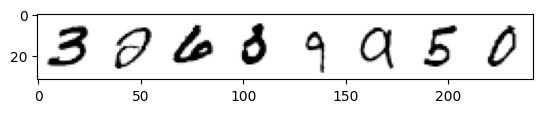

In [61]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

我其實沒有學過diffusion
但是逐步添加高斯噪声來生成新的數據，
`noise = torch.rand_like(x)` 噪音
`noisy_x =  (1-amount)*x + amount*noise` 加噪

In [62]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount 

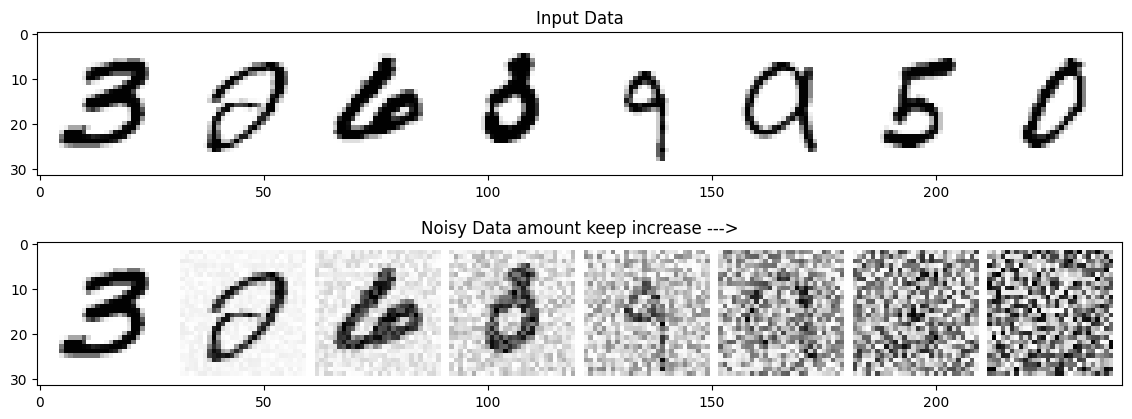

In [63]:
fig, axs = plt.subplots(2, 1, figsize=(14, 5))
axs[0].set_title('Input Data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# add noise
amount = torch.linspace(0, 1, x.shape[0])
noisy_x = corrupt(x, amount)

# 新圖像
axs[1].set_title('Noisy Data amount keep increase --->')
axs[1].imshow(torchvision.utils.make_grid(noisy_x)[0], cmap='Greys')

In [64]:
# unet
class UNet(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2)
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2)
        ])
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2: # For all but the third (final) down layer:
                h.append(x) # Storing the output of each down layer for skpping(可以先存起來)
                x = self.downscale(x) 
        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
                x = self.upscale(x)
                x += h.pop() # 最後把存起來的數據再相加回去
            x = self.act(l(x))
        return x

In [65]:
unet = UNet()
x  = torch.rand(8, 1, 28, 28)
unet(x).shape

torch.Size([8, 1, 28, 28])

In [66]:
t = 0
for p in unet.parameters():
    t += p.numel();

309057


# Training the network

Epoch 1, Loss: 0.0265
Epoch 2, Loss: 0.0205
Epoch 3, Loss: 0.0187


(0.0, 0.1)

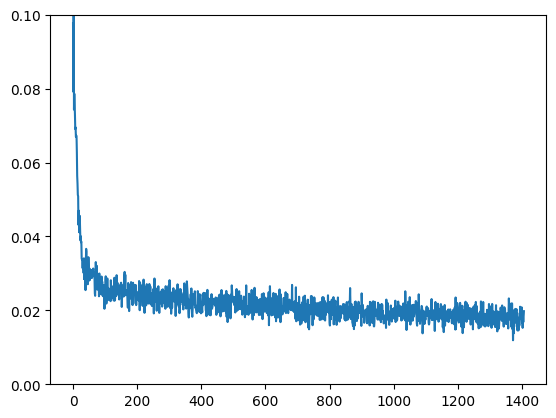

In [85]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# run 3 times
n_epochs = 3

# Create the network
net = UNet()
net.to(device)

# optim
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# loss function
loss_fn = nn.MSELoss()

# loss
losses = []

for epoch in range(n_epochs):
    for i, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        noise_amout = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amout)
        
        # pred
        pred = net(noisy_x)
        loss = loss_fn(pred, x)
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
    total_loss = 0
    for loss in losses[-len(train_dataloader):]:
        total_loss += loss
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

plt.plot(losses)
plt.ylim(0, 0.1)

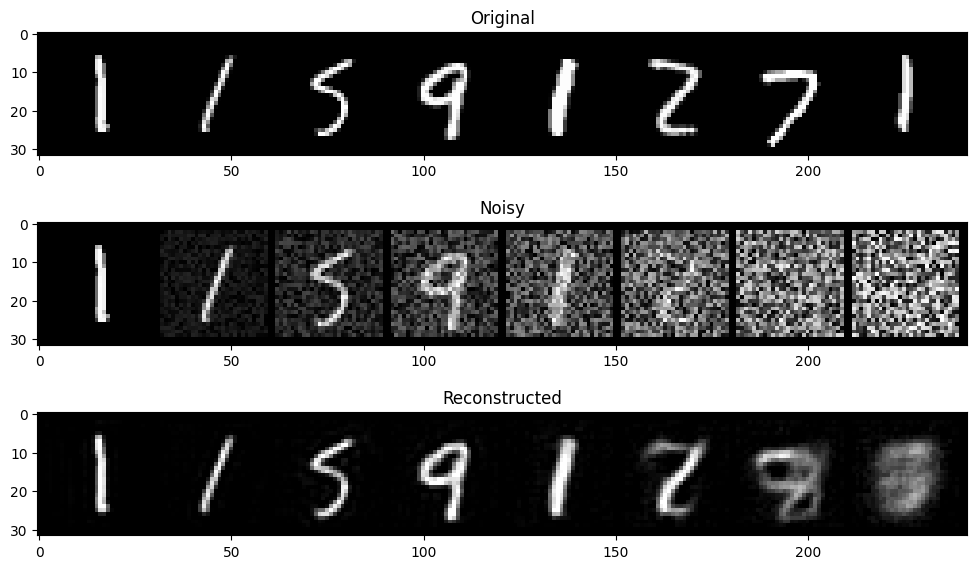

In [87]:
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # only first 8 images

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

with torch.no_grad():
    pred = net(noised_x.to(device)).detach().cpu()

# plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Original')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')

axs[1].set_title('Noisy')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')

axs[2].set_title('Reconstructed')
axs[2].imshow(torchvision.utils.make_grid(pred)[0].clip(0, 1), cmap='Greys')